# Лабораторна робота №6  
## Тема: Класифікація фейкових новин за допомогою RNN та LSTM  
### Дисципліна: Машинне навчання  
### Виконала: студентка групи ФЕІ-44 Гаркуша Юлія

---

### **Мета роботи**
1. Ознайомитися з рекурентними нейронними мережами (RNN) та LSTM.  
2. Здійснити повний цикл побудови текстового класифікатора.  
3. Провести препроцесинг тексту, токенізацію та побудову словника.  
4. Навчити дві моделі (RNN та LSTM) для класифікації новин на *фейкові* та *справжні*.  
5. Порівняти моделі за метриками: Accuracy, Precision, Recall, F1-score, ROC AUC.  
6. Побудувати графіки навчання й оцінки моделей.

## 1. Імпорт необхідних бібліотек

У цьому блоці ми імпортуємо всі потрібні інструменти:
- **pandas, numpy** — робота з даними  
- **re, nltk** — очищення тексту та токенізація  
- **PyTorch (torch, nn)** — побудова моделей RNN/LSTM  
- **sklearn.metrics** — розрахунок метрик  
- **matplotlib** — побудова графіків  

Також завантажуємо токенізатор NLTK.


In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

nltk.download("punkt_tab")
nltk.download("punkt")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\uula2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uula2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Завантаження та об’єднання датасетів

Тут завантажуються два CSV-файли:
- `Fake.csv` — фейкові новини  
- `True.csv` — справжні новини  

Ми додаємо колонку `label`, де:
- **1 = Fake**  
- **0 = True**

Після цього об’єднуємо датасети в один та перемішуємо для рівномірності.


In [2]:
fake_path = r"D:\4K\Машинне навчання\Labs\6\Fake.csv"
true_path = r"D:\4K\Машинне навчання\Labs\6\True.csv"

df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

df_fake["label"] = 1
df_true["label"] = 0

df = pd.concat([df_fake, df_true]).sample(frac=1).reset_index(drop=True)

df.head()


,title,text,subject,date,label
0,WHOA! BILL O’REILLY DROPS BOMBSHELL Report Abo...,Bill O Reilly needs to ask the investigators a...,politics,"Sep 17, 2017",1
1,U.S. intel chief says has no 'relevant' memo o...,WASHINGTON (Reuters) - Director of National In...,politicsNews,"May 23, 2017",0
2,"Watch Out, Clarence Thomas: Petition Asks Pre...",Conservatives would be so pissed if this actua...,News,"February 14, 2016",1
3,“BLOOD ON THEIR HANDS” FOR VOTING RIGHTS: The ...,It s time to stop hitting the snooze button Am...,Government News,"Aug 9, 2015",1
4,Judge orders Illinois to boost Medicaid bill p...,CHICAGO (Reuters) - A U.S. judge on Friday dea...,politicsNews,"June 30, 2017",0


## 3. Попередня очистка текстових даних

Цей блок виконує мінімальний текстовий препроцесинг:
- перетворення тексту в нижній регістр  
- видалення цифр, спецсимволів, зайвих пробілів  
- об’єднання заголовку та тексту статті  
- очищення за допомогою регулярних виразів  

На виході ми отримуємо базово нормалізований текст.


In [3]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["text"] = (df["title"] + " " + df["text"]).apply(clean_text)


## 4. Токенізація та побудова словника

### Основні дії:
1. **Токенізація** кожної статті (розбиття на слова).  
2. **Побудова словника (vocabulary)** на основі найчастотніших слів (топ 20 000).  
3. Додавання спеціальних токенів:
   - `<PAD>` — для доповнення рядків  
   - `<UNK>` — для невідомих слів  
4. **Кодування тексту** у числові послідовності з фіксованою довжиною (200 токенів).

Це необхідно для подачі текстів у нейронну мережу.


In [4]:
from nltk.tokenize import word_tokenize

df["tokens"] = df["text"].apply(word_tokenize)

# УТВОРЕННЯ СЛОВНИКА
all_tokens = [token for row in df["tokens"] for token in row]

freq = nltk.FreqDist(all_tokens)
vocab = ["<PAD>", "<UNK>"] + [word for word, _ in freq.most_common(20000)]
word2idx = {w: i for i, w in enumerate(vocab)}

def encode(tokens, max_len=200):
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids

df["input_ids"] = df["tokens"].apply(lambda x: encode(x, 200))

X = np.array(df["input_ids"].tolist())
y = df["label"].values


## 5. Розбиття даних на Train / Validation / Test

Ми ділимо вхідні дані у пропорції:
- 80% — тренувальна вибірка  
- 10% — валідаційна  
- 10% — тестова

Це дозволяє:
- тренувати модель  
- підбирати гіперпараметри  
- чесно оцінити якість на невідомих прикладах  


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)


(35918, 4490, 4490)

## 6. Створення PyTorch Dataset та DataLoader

На цьому етапі:
- Перетворюємо дані у формат тензорів  
- Створюємо власний клас Dataset  
- Формуємо DataLoader-и для батчової подачі даних

DataLoader оптимізує:
- швидкість навчання  
- роботу GPU/CPU  
- зручність повторів епох  


In [6]:
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = NewsDataset(X_train, y_train)
val_ds = NewsDataset(X_val, y_val)
test_ds = NewsDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)


## 7. Модель простої RNN

Тут створюється класична рекурентна нейронна мережа:
- **Embedding layer** — перетворює індекси слів у векторні подання  
- **RNN layer** — обробляє текст послідовно  
- **Linear layer** — видає прогноз (фейк / не фейк)

Ця модель проста, але менш потужна, ніж LSTM.


In [7]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        out, h = self.rnn(emb)
        last = h[-1]
        logits = self.fc(last)
        return logits


## 8. Модель LSTM

LSTM — покращена версія RNN, здатна:
- запам’ятовувати інформацію на довші послідовності  
- краще справлятися з контекстом  
- давати вищу точність на текстових задачах  

Структура:
- Embedding  
- LSTM  
- Linear  


In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        last = h[-1]
        logits = self.fc(last)
        return logits


## 9. Функція навчання моделі

У цьому блоці:
- визначається оптимізатор Adam  
- вибирається функція втрат BCEWithLogits  
- запускається цикл навчання на N епох  
- обчислюються train та validation loss  

Функція використовується для навчання як RNN, так і LSTM.


In [9]:
def train_model(model, train_loader, val_loader, epochs=3, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for Xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(Xb).squeeze(1)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # VAL
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                logits = model(Xb).squeeze(1)
                loss = criterion(logits, yb)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1} | Train loss={train_losses[-1]:.4f}, Val loss={val_losses[-1]:.4f}")

    return train_losses, val_losses


## 10. Навчання моделі RNN

Запускаємо тренування RNN:
- обчислюємо train/val loss  
- зберігаємо історію для подальшої візуалізації

In [10]:
rnn_model = SimpleRNNClassifier(vocab_size=len(vocab))
rnn_train_loss, rnn_val_loss = train_model(rnn_model, train_loader, val_loader, epochs=3)


Epoch 1 | Train loss=0.6569, Val loss=0.6647
Epoch 2 | Train loss=0.6393, Val loss=0.6729
Epoch 3 | Train loss=0.6409, Val loss=0.6222


## 11. Навчання моделі LSTM

Так само запускається навчання LSTM.  
Порівняння результатів допоможе визначити, яка модель працює краще.


In [11]:
lstm_model = LSTMClassifier(vocab_size=len(vocab))
lstm_train_loss, lstm_val_loss = train_model(lstm_model, train_loader, val_loader, epochs=3)

Epoch 1 | Train loss=0.6388, Val loss=0.6185
Epoch 2 | Train loss=0.5210, Val loss=0.4255
Epoch 3 | Train loss=0.3552, Val loss=0.1620


## 12. Порівняння кривих навчання RNN та LSTM

Ми будуємо графік:
- тренувальних втрат  
- валідаційних втрат  

Це дозволяє:
- оцінити стабільність навчання  
- виявити можливе перенавчання  
- порівняти моделі між собою  


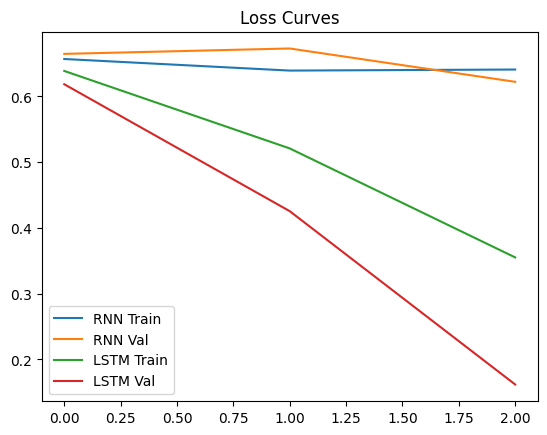

In [12]:
plt.plot(rnn_train_loss, label="RNN Train")
plt.plot(rnn_val_loss, label="RNN Val")
plt.plot(lstm_train_loss, label="LSTM Train")
plt.plot(lstm_val_loss, label="LSTM Val")
plt.legend()
plt.title("Loss Curves")
plt.show()


## 13. Оцінка моделей на тестовій вибірці

Ми отримуємо передбачення моделей на unseen-тестових даних.  
Далі формуємо:
- справжні мітки (`y_true`)  
- передбачені мітки (`y_pred`)  

Це використовується для подальших метрик.


In [13]:
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for Xb, yb in loader:
            logits = model(Xb).squeeze(1)
            probs = torch.sigmoid(logits)
            preds.extend((probs > 0.5).int().tolist())
            trues.extend(yb.tolist())

    return np.array(trues), np.array(preds)


y_true_rnn, y_pred_rnn = evaluate(rnn_model, test_loader)
y_true_lstm, y_pred_lstm = evaluate(lstm_model, test_loader)


## 14. Обчислення основних метрик

Ми розраховуємо:
- **Accuracy** — загальна точність  
- **Precision** — точність позитивного класу  
- **Recall** — повнота  
- **F1-score** — збалансована метрика  
 
Це дозволяє глибоко порівняти RNN і LSTM.


In [14]:
def print_metrics(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))

print_metrics("RNN", y_true_rnn, y_pred_rnn)
print_metrics("LSTM", y_true_lstm, y_pred_lstm)



=== RNN ===
Accuracy: 0.6712694877505568
Precision: 0.6691635455680399
Recall: 0.7024901703800787
F1: 0.6854219948849105

=== LSTM ===
Accuracy: 0.9483296213808463
Precision: 0.9668633681343622
Recall: 0.9305373525557011
F1: 0.9483526268922529


## 15. ROC AUC — якість ранжування моделей

ROC AUC оцінює, наскільки добре модель:
- розділяє класи  
- працює з різними порогами  
- не залежить від конкретного threshold (0.5)

Це одна з найважливіших метрик у бінарній класифікації.


In [15]:
def get_probs(model, loader):
    model.eval()
    probs = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            logits = model(Xb).squeeze(1)
            p = torch.sigmoid(logits)
            probs.extend(p.tolist())
            trues.extend(yb.tolist())
    return np.array(trues), np.array(probs)


y_true_rnn, rnn_probs = get_probs(rnn_model, test_loader)
y_true_lstm, lstm_probs = get_probs(lstm_model, test_loader)

print("RNN ROC-AUC:", roc_auc_score(y_true_rnn, rnn_probs))
print("LSTM ROC-AUC:", roc_auc_score(y_true_lstm, lstm_probs))


RNN ROC-AUC: 0.7255279730072255
LSTM ROC-AUC: 0.9733375095199787


## 16. Побудова ROC-кривої

ROC-крива показує:
- trade-off між True Positive Rate та False Positive Rate  
- порівняння ефективності RNN та LSTM  

Зазвичай LSTM має вищу AUC ніж RNN.


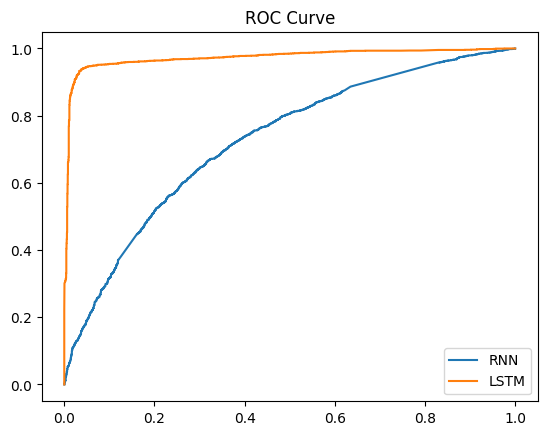

In [16]:
fpr_rnn, tpr_rnn, _ = roc_curve(y_true_rnn, rnn_probs)
fpr_lstm, tpr_lstm, _ = roc_curve(y_true_lstm, lstm_probs)

plt.plot(fpr_rnn, tpr_rnn, label="RNN")
plt.plot(fpr_lstm, tpr_lstm, label="LSTM")
plt.legend()
plt.title("ROC Curve")
plt.show()


## 17. Матриця неточностей (Confusion Matrix)

Ця матриця показує:
- скільки прикладів модель класифікувала правильно  
- де траплялися помилки  
- які саме класи плуталися між собою  

Це важлива фінальна оцінка моделей.


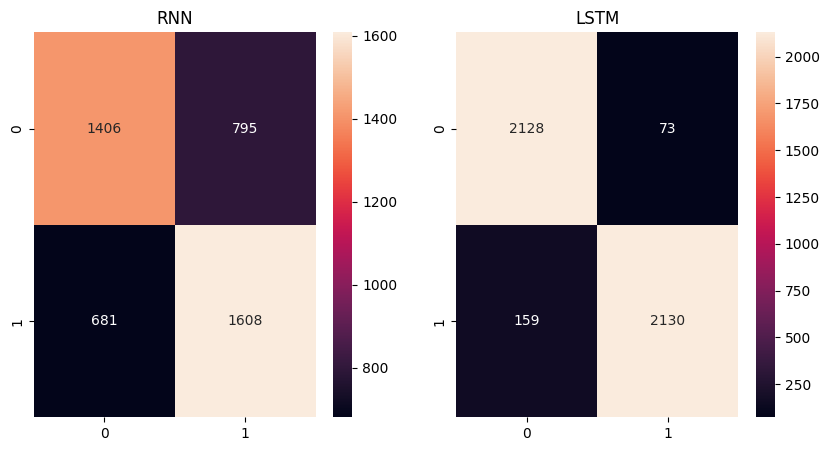

In [17]:
import seaborn as sns

cm_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(cm_rnn, annot=True, ax=ax[0], fmt="d")
sns.heatmap(cm_lstm, annot=True, ax=ax[1], fmt="d")
ax[0].set_title("RNN")
ax[1].set_title("LSTM")
plt.show()


## Висновки

У ході лабораторної роботи було реалізовано два підходи до класифікації фейкових новин:  
1) модель на основі простої рекурентної нейронної мережі (RNN),  
2) модель на основі LSTM – покращеної рекурентної архітектури з механізмами довготривалої пам’яті.

### Порівняння навчання моделей

Аналіз кривих втрат показав суттєву різницю між моделями.  
RNN демонструє незначне зменшення train та validation loss, що свідчить про обмежену здатність враховувати довгі текстові залежності.  
На відміну від неї, LSTM стабільно та швидко знижує функцію втрат і на тренуванні, і на валідації. Це вказує на ефективне засвоєння контексту та відсутність перенавчання.

### Якість класифікації

Метрики точності підтверджують перевагу LSTM:

- **RNN:** Accuracy ≈ 0.67, F1 ≈ 0.68  
- **LSTM:** Accuracy ≈ 0.95, F1 ≈ 0.95  

Таким чином, LSTM майже в півтора рази перевершує RNN за точністю та повнотою.

### Аналіз ROC-кривих

ROC-крива RNN показує середній рівень розділення класів, тоді як LSTM формує майже ідеальну криву з AUC, близьким до 1.  
Це означає, що LSTM набагато впевненіше відрізняє фейкові новини від справжніх, незалежно від обраного порогу класифікації.

### Матриця неточностей

Confusion matrix підтверджує отримані метрики:  
RNN робить значну кількість помилок у визначенні обох класів, тоді як LSTM має мінімальну кількість хибнопозитивних та хибнонегативних передбачень.  
LSTM практично не плутає класи, що є визначальною ознакою якісного текстового класифікатора.

### Загальний висновок

Проведені експерименти демонструють, що LSTM є значно ефективнішою моделлю для задачі класифікації тексту.  
Її здатність запам’ятовувати довготривалі залежності, фільтрувати неважливу інформацію та краще моделювати контекст робить її придатною для задач обробки природної мови, зокрема для визначення фейкових новин.

Таким чином, у межах даної лабораторної роботи **LSTM показала набагато вищу якість класифікації**, перевершивши просту RNN за всіма ключовими метриками та візуальними показниками.
